<a href="https://colab.research.google.com/github/manuelboi/AI_project/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



In [11]:
def show_single_letter(xi):
  # take pytorch tensor and convert it into numpy array, then reshape into 28x28
  xi = xi.numpy()
  #xi = xi.numpy().reshape(28, 28)
  ax = plt.gca()
  ax.grid(color='r')
  plt.xticks(range(0, xi.shape[0]+1), fontsize=5)
  plt.yticks(range(0, xi.shape[0]+1), fontsize=5)
  # specific values associated to "extent" attribute in order to place pixel positions precisely in the plot
  # show the transposed "matrix" of the grey-scale images
  plt.imshow(np.transpose(xi), extent=(0, xi.shape[0], xi.shape[0], 0), cmap='Greys', vmin=0, vmax=255)

def show_letters(x, n=10):
  for i in range(n**2):
    plt.subplot(n, n, i+1)
    show_single_letter(x[i])


input_size = 28 * 28
num_classes = 26

# 124800 training set images
train_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                        train=True, download=True,
                                        transform=transforms.ToTensor())

# 20800 test set images
test_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                       train=False,
                                       transform=transforms.ToTensor())
# tr_images and labels are tensors
tr_images = train_set.data
labels = train_set.targets
print(labels)

classes = train_set.classes
print(classes)



# plot a single image
#show_single_letter(tr_images[0])

# show_letters(tr_images, 12)




tensor([23,  7, 16,  ..., 13, 15, 19])
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Understanding tensors

In [12]:
print(tr_images)
print(tr_images.size())
print(tr_images[0])
print(tr_images[0].size())

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

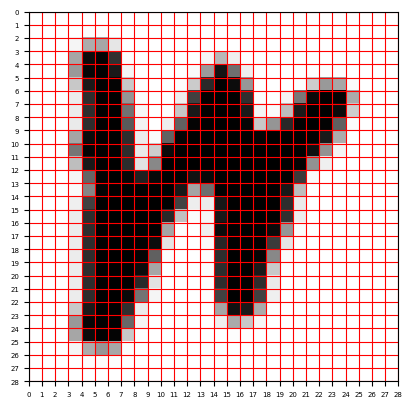

In [13]:
show_single_letter(tr_images[0])

Elia - Binarizzazione dell'immagine

Class:  w


'thresh = 128\nmaxval=255\n\nim_bin = (tr_images[0] > thresh)*maxval\n#print(im_bin)\nshow_single_letter(im_bin)'

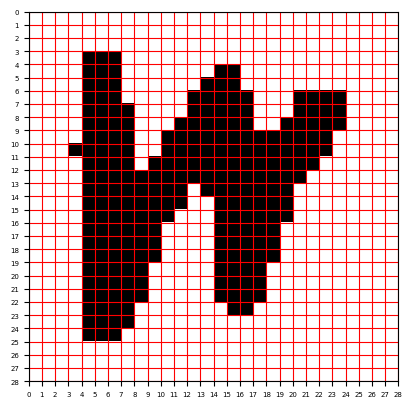

In [19]:
def binarize(image, threshold, max_value):
  return (image > threshold) * max_value

threshold = 128
max_value = 255

index_letter = 0
bin_img = binarize(tr_images[index_letter], 128, 255)
show_single_letter(bin_img)
print("Class: ", classes[labels[index_letter]])


# original code by Elia
"""thresh = 128
maxval=255

im_bin = (tr_images[0] > thresh)*maxval
#print(im_bin)
show_single_letter(im_bin)"""


Matteo - Implementazione della maschera per scheletrizzazione

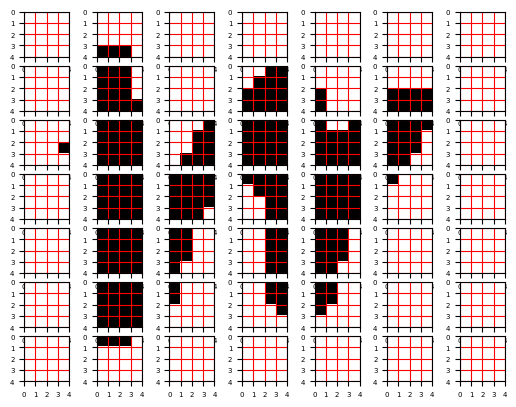

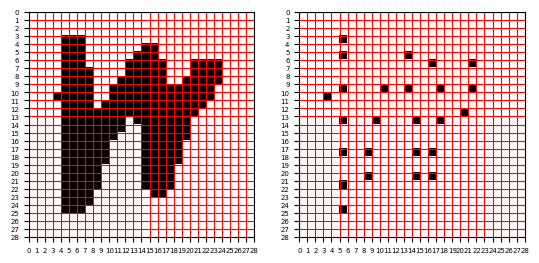

In [20]:
def compute_centroid(image):

  xis, yis = np.nonzero(image.numpy())
  if xis.size or yis.size != 0:
    return int(xis.mean()), int(yis.mean())

  return None, None


def show_subimages(image, dim_mask):

  # use the transposed image so that at the end it doesn't plot a "rotated" image
  image_T = np.transpose(image)

  a = 0
  for i in range(0, image.size()[0], dim_mask):
    for j in range(0, image.size()[1], dim_mask):
      a += 1
      if a > 49:
        break
      sub_img = image_T[i:i+dim_mask, j:j+dim_mask]
      plt.subplot(7, 7, a)

      #imshow plot white either if all pixels = 0 or all pixels = 255. To display black when all values = 255, use vmin=0 and vmax=255
      #plt.imshow(sub_img, cmap="Greys", vmin=0, vmax=255)
      show_single_letter(np.transpose(sub_img))


def sample_image(image, dim_mask):

  image_T = np.transpose(image)

  # image that will be obtained from the computed centroids
  sample_img = torch.zeros(image.size())
  # be careful: at the beginning the mask moves from left to right, then from right
  # to left and so on (right to left everytime "i" is odd)
  start = 0
  stop = image.size()[1]
  step = dim_mask
  for i in range(0, image.size()[0], dim_mask):
    for j in range(start, stop, step):
      sub_img = image_T[i:i+dim_mask, j:j+dim_mask]

      c_ri, c_ci = compute_centroid(sub_img)

      if (c_ri, c_ci) != (None, None):
        #Shifting centroids in the new tensor sample_img
        sample_img[c_ri+i, c_ci+j] = 255

    # if j = 24 it means it's on the right side of the image
    # so in the next turn j will decrease to 20
    if j == image.size()[1] - dim_mask:
      start = j
      stop = -1
      step = -(dim_mask)
    else:
      start = 0
      stop = image.size()[1]
      step = dim_mask

  return sample_img


dim_mask = 4

sample_img = sample_image(bin_img, dim_mask)



plt.figure(1)
show_subimages(bin_img, dim_mask)
plt.figure(2)
plt.subplot(121)
show_single_letter(bin_img)
plt.subplot(122)
show_single_letter(sample_img.T)




